# Double Pendulum Using the Lagrangian Method

Uses the Pendulum class to solve for the motion of two pendulums using the Euler-Lagrange Equations.

## Derivation of Euler-Lagrange Equations
<img src='doublep.png' width = "400">

For the two pendulum bobs above, the generalized coordinates will be their angular positions $\phi_1$ and $\phi_2$ from the downward vertical. The angle between the velocity vectors, $L_1\dot\phi_1$ and $L_2\dot\phi_2$ is the difference between these angles, $\phi_1 - \phi_2$. The kinetic and potential energies are given by:

$\begin{align}
T = \frac{1}{2}m_1(L_1\dot\phi_1)^2 + \frac{1}{2}m_2[(L_1\dot\phi_1)^2 + 2 L_1 L_2 \dot\phi_1\dot\phi_2 \cos(\phi_1 - \phi_2) + (L_2\dot\phi_2)^2]
\end{align}$

$\begin{align}
U = m_1 g L_1 (1-\cos\phi_1) + m_2 g[L_1 (1-\cos\phi_1) + L_2 (1-\cos\phi_2)]
\end{align}$

It is easy to see what the Lagrangian, $\mathcal{L} = T - U$, will be so we will go ahead and use this to derive the equations of motion from Lagrange's equations:
$\begin{align}
\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_1} = \frac{\partial\mathcal L}{\partial\phi_1}
 \quad\Longrightarrow\quad L_1 \ddot\phi_1 (m_1 + m_2) + L_2 m_2 \ddot\phi_2 \cos(\phi_1 - \phi_2) = -L_2 m_2 (\dot\phi_2)^2 \sin(\phi_1 - \phi_2) - g (m_1 + m_2) \sin\phi_1
\end{align}$

$\begin{align}
\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi_2} = \frac{\partial\mathcal L}{\partial\phi_2}
 \quad\Longrightarrow\quad g \sin\phi_2 + L_1 \ddot\phi_1 \cos(\phi_1 - \phi_2) + L_2 \ddot\phi_2 = L_1 (\dot\phi_1)^2 \sin(\phi_1 - \phi_2)
\end{align}$

Or by solving for $\ddot\phi_1$ and $\ddot\phi_2$ only:

$\begin{align}
\ddot\phi_1 = \frac{-g (m_1 + m_2) \sin\phi_1 + L_2 m_2 (\dot\phi_2)^2 \sin(\phi_1 - \phi_2) - L_1 m_2 (\dot\phi_1)^2 \cos(\phi_1 - \phi_2) \sin(\phi_1 - \phi_2) + g m_2 \cos(\phi_1 - \phi_2) \sin\phi_1 }{L_1(m_1 + m_2) - L_1 m_2 (\cos(\phi_1 - \phi_2))^2}
\end{align}$

$\begin{align}
\ddot\phi_2 = \frac{(m_1 + m_2)[g \cos(\phi_1 - \phi_2) \sin\phi_1 + L_1 (\dot\phi_1)^2 \sin(\phi_1 - \phi_2) - g \sin\phi_2] - L_2 m_2 \cos(\phi_1 - \phi_2) \sin(\phi_1 - \phi_2) }{L_2(m_1 + m_2) - L_2 m_2 (\cos(\phi_1 - \phi_2))^2}
\end{align}$

Whew, that's a lot to unpack. So let's unpack it.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [4]:
#Resolution stuff
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum Class and Functions

In [5]:
class Pendulum():
    """
    This class uses Lagrange's equations and solve_ivp to detail the motion of the double pendulum!
     
    Parameters
    ----------
    L_1 : float
        length of pendulum 1
    L_2 : float
        length of pendulum 2
    g : float
        gravitational acceleration at the earth's surface 
    mass_1 : float
        mass of pendulum 1
    mass_2 : float
        mass of pendulum 2

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L_1=1., L_2=1., mass_1=1., mass_2=1., g=1.
                ):
        self.L_1 = L_1
        self.L_2 = L_2
        self.g = g
        self.mass_1 = mass_1
        self.mass_2 = mass_2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi_i/dt d^2phi_i/dt^2] for the i'th pendulum
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with y[0] = phi_1(t), y[1] = dphi_1/dt, y[2] = phi_2(t), y[3] = dphi_2/dt
            
        Returns
        -------
        [y[1], d^2phi_1/dt^2, y[3], d^2phi_2/dt^2]
        """
        #Define expressions to help with formatting
        c = np.cos(y[0] - y[2])
        s = np.sin(y[0] - y[2])
        denom = self.mass_1 + self.mass_2 - self.mass_2 * c**2
        return [y[1], ( -(self.mass_1 + self.mass_2) * self.g*np.sin(y[0]) \
                        - self.L_2 * self.mass_2 * y[3]**2 * s \
                        - self.L_1 * self.mass_2 * y[1]**2 * c * s \
                        + self.g * self.mass_2 * c * np.sin(y[2]) ) \
                       / (self.L_1 * denom),
                y[3], 
                    ( (self.mass_1 + self.mass_2)*(self.g * c * np.sin(y[0]) \
                        + self.L_1 * y[1]**2 * s \
                        - self.g*np.sin(y[2]) ) \
                      + self.L_2*self.mass_2* y[3]**2 * c * s ) \
                     / (self.L_2 * denom)]

    
    
    def solve_ode(self, t_pts, phi_01, phi_dot_01, phi_02, phi_dot_02,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_01, phi_dot_01, phi_02, phi_dot_02] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi_1, phi_dot_1, phi_2, phi_dot_2 = solution.y

        return phi_1, phi_dot_1, phi_2, phi_dot_2

In [6]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [7]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Double Pendulum Plots
First let's instantiate the pendulum then utilize the class functions to plot!

In [8]:
# Choose a plotting time window
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Set the parameter values
L_1 = 1.
L_2 = 1.
g = 1.
mass_1 = 1.
mass_2 = 1.

# Instantiate a pendulum system as p 
p = Pendulum(L_1=L_1, L_2=L_2, mass_1=mass_1, mass_2=mass_2, g=g)


(<matplotlib.axes._subplots.AxesSubplot at 0x1517a8f650>,
 <matplotlib.lines.Line2D at 0x1517b1ec90>)

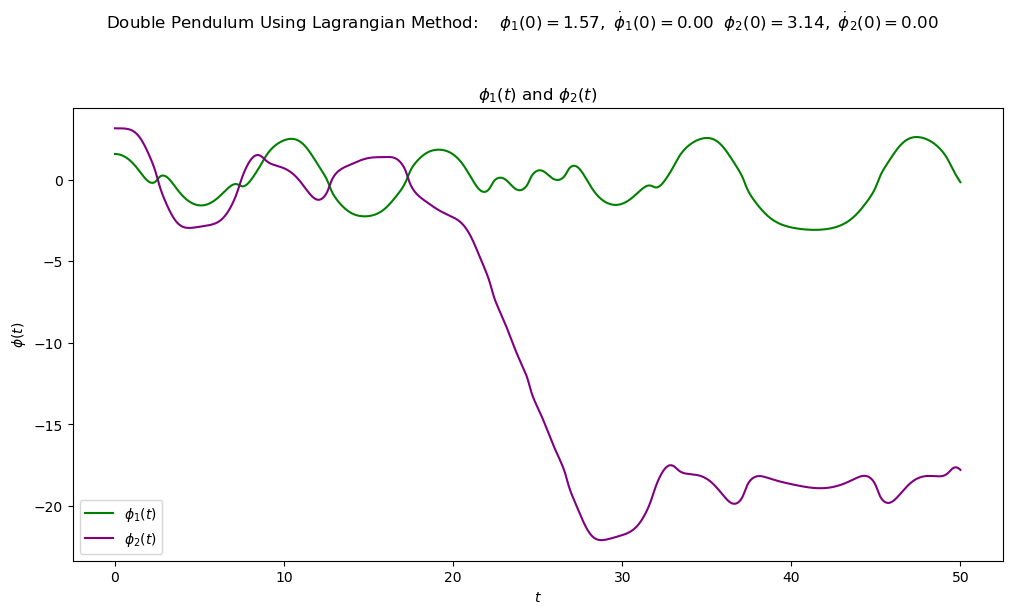

In [14]:
# Set up the initial conditions for each pendulum and solve the diff-eq numerically
phi_01 = np.pi / 2.
phi_dot_01 = 0.
phi_02 = np.pi
phi_dot_02 = 0.
phi_1, phi_dot_1, phi_2, phi_dot_2 = p.solve_ode(t_pts, phi_01, phi_dot_01, 
                                                 phi_02, phi_dot_02)


# Plot phi vs time
fig = plt.figure(figsize=(12,6))
overall_title = 'Double Pendulum Using Lagrangian Method:  ' + \
                rf'  $\phi_1(0) = {phi_01:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_dot_01:.2f}$' + \
                rf'  $\phi_2(0) = {phi_02:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_dot_02:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
ax_a = fig.add_subplot(1,1,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi_1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='green',
            label= r'$\phi_1(t)$', 
            title=r'$\phi_1(t)$ ' + 'and ' + r'$\phi_2(t)$', 
            ax=ax_a)   
plot_y_vs_x(t_pts[start : stop], phi_2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='purple',
            label= r'$\phi_2(t)$', 
            ax=ax_a)   
fig.tight_layout()

## Nonlinearity and Chaos
You might be wondering if this system is chaotic. Your intuition is correct. We get the sense from the lack of periodicity in the above graph that there might be chaos. Since we have not used the small angle approximation in the differential equation, we should not be surprised to find chaos since there are nonlinear terms, such as the sine and cosine terms.

We can plot the difference between the two pendulum bobs, 1 and 2, or $\Delta\phi$ with time on a semilog scale. If this system were nonchaotic, then the pendulum motion for both bobs should become the same, or that $\Delta\phi$ should approach zero. If the system has chaos, then the pendula should become more and more different.

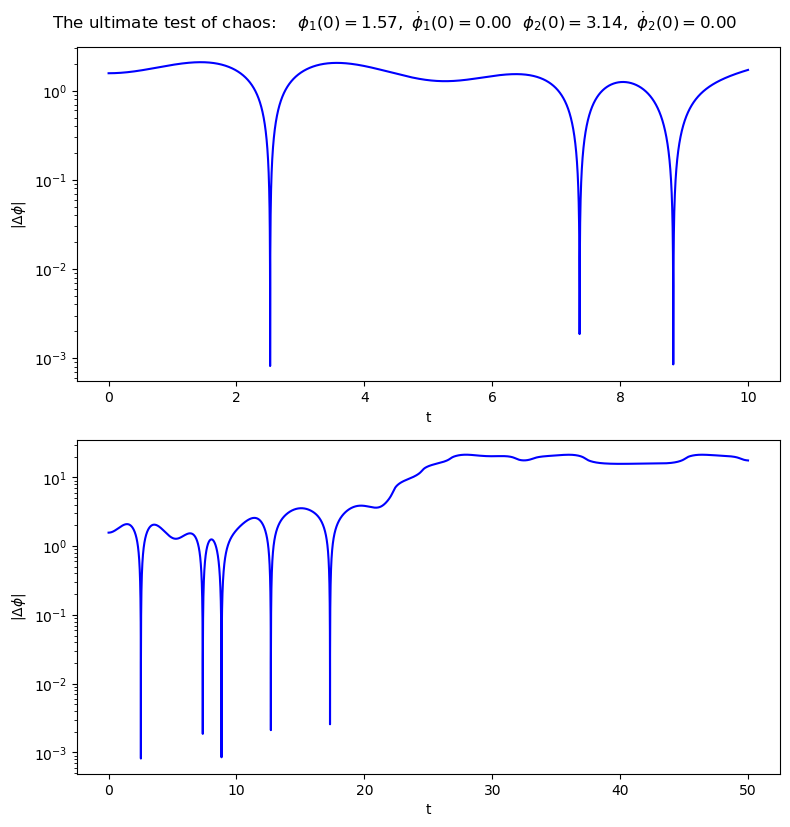

In [15]:
# Calculate the absolute value of \phi_2 - \phi_1
Delta_phi = np.fabs(phi_2 - phi_1)


# start the plot!
fig = plt.figure(figsize=(8,8))
overall_title = 'The ultimate test of chaos:  ' + \
                rf'  $\phi_1(0) = {phi_01:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_dot_01:.2f}$' + \
                rf'  $\phi_2(0) = {phi_02:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_dot_02:.2f}$' + \
                '\n'     
fig.suptitle(overall_title, va='baseline')
    
# two plots: plot from t=0 to t=10 for a short time scale and another from t=0 to t=100 for a long time scale
ax_a = fig.add_subplot(2,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 10.)
ax_a.semilogy(t_pts[start : stop], Delta_phi[start : stop], 
            color='blue', label=None) 
ax_a.set_xlabel('t')
ax_a.set_ylabel(r'$|\Delta\phi|$')

ax_b = fig.add_subplot(2,1,2)                  

start, stop = start_stop_indices(t_pts, 0., 100.)
plot_y_vs_x(t_pts[start : stop], Delta_phi[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel('t')
ax_b.set_ylabel(r'$|\Delta\phi|$')
                              
fig.tight_layout()

Dang. Ain't she a beaut? A shorter time scale from t = 0 to t = 10 does not give us that much information, but we see that $\Delta\phi$ does not decrease in this time. On a larger scale, up to t = 100, we see that $\Delta\phi$ actually increases by one order of magnitude, so there is definitely chaos!

We can also do a perodicity check by making state space plots for each pendulum.

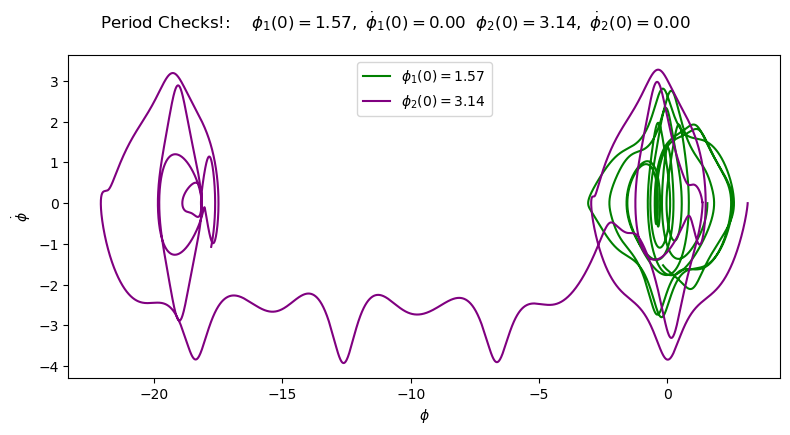

In [20]:
fig = plt.figure(figsize=(8,4))
overall_title = 'Period Checks!:  ' + \
                rf'  $\phi_1(0) = {phi_01:.2f},$' + \
                rf' $\dot\phi_1(0) = {phi_dot_01:.2f}$' + \
                rf'  $\phi_2(0) = {phi_02:.2f},$' + \
                rf' $\dot\phi_2(0) = {phi_dot_02:.2f}$' + \
                '\n'    
fig.suptitle(overall_title, va='baseline')
    
# Plot from t=0 to t=50  
ax_a = fig.add_subplot(1,1,1)                  
ax_a.set_ylabel(r'$\dot\phi$')
ax_a.set_xlabel(r'$\phi$')

start, stop = start_stop_indices(t_pts, 0., 50.)    
plot_y_vs_x(phi_1[start : stop], phi_dot_1[start : stop], 
            color='green',
            label=rf'$\phi_1(0) = {phi_01:.2f}$', 
            ax=ax_a)    
plot_y_vs_x(phi_2[start : stop], phi_dot_2[start : stop], 
            color='purple',
            label=rf'$\phi_2(0) = {phi_02:.2f}$', 
            ax=ax_a)      

fig.tight_layout()

If the system were in any way linear, then the purple and green curves would trace over themselves in some way. This is the plot of $\dot\phi$ vs $\phi$ for the time interval t = 0 to t = 50. At any given t, a pendulum as a particular state, or position and velocity. This may be represented by a loop in a plot like the one above. If the pendulum has this same state at a different t, the loop traces over itself. Thus, if the pendulum is continuously repeating these sates, then it has a periodic motion charactaeristic of closed loops in state space, and the system is said to be linear. Unfortunately neither pendulum closes in on itself during the first 50 t units of this motion. The first pendulum seems a bit more contained like it is trying to maintain some periodicity, but the second pendulum is completely chaotic.